# Man vs machine notebook
this notebook is to check whether all the analytical calculations (which we use for the montecarlo algorithm) agree with less-computationally robust, but conceptually more trustworthy numerical calculations.

idea: check numerical vs analytic calculations piece by piece


# Jastrow factor

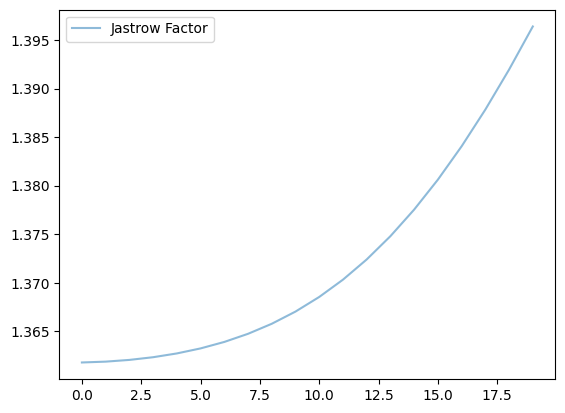

In [429]:


import numpy as np
#import kinetic_energy as kin
import libraryMetropolis as kin
import importlib
import matplotlib.pyplot as plt

importlib.reload(kin)

def jastrow(N,R,N_up,b_par,b_anti):
    jastrow_log = 0.
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.linalg.norm(R[i] - R[j])
    #         print("mb rij",r_ij)
            spin_alignment = 1 if (i < N_up and j < N_up) or (i >= N_up and j >= N_up) else 0
    #         print("spin alignment mb",spin_alignment)
            bij = kin.b_ij(spin_alignment, b_par, b_anti)
            aij = kin.a_ij(spin_alignment)
            jastrow_log += aij * r_ij / (1 + bij * r_ij)
    jastrow_factor = np.exp(jastrow_log)
    return jastrow_factor

box_size = 2 
N = 2
sigma = 1
b1=1
b2=1
jastrow_J = lambda X: jastrow(N, X, kin.N_up_choice(N), b_par=b1, b_anti=b2)
R_test = np.random.uniform(0, box_size, size=(N,2))

length = 20
jastrow_array = np.zeros(length)
jastrow_array_f = np.zeros(length)
for i in range(length):
    R_test[N-1][1]= R_test[N-1][1] + i/200  # Example positions for testing  
    jastrow_array[i] = jastrow(N, R_test, kin.N_up_choice(N), b_par = 1.0, b_anti = 1.0)
plt.plot(np.arange(length), jastrow_array, label='Jastrow Factor',alpha=0.5)
plt.legend()



# Kinetic energy integrand

## Total kinetic energy integrand

In [431]:
import importlib
import libraryMetropolis as kin
import numpy as np
importlib.reload(kin)
# Parameters
N = 2
N_up = kin.N_up_choice(N)
sigma = 1
b_par = 1
b_anti = 1
omega = 1
use_chi = True

# Define a grid of positions (e.g., 3 particles in 2D)

    
box_size = 1
R = np.random.uniform(0, box_size, size=(N, 2))
#phi0 =  partial(kin.single_particle_wf, m=0, sigma = sigma, use_chi = use_chi)
#phi_plus =  partial(kin.single_particle_wf, m=1, sigma = sigma, use_chi = use_chi)
#phi_minus =  partial(kin.single_particle_wf, m=-1, sigma = sigma, use_chi=use_chi)

#print(kin.gradient_phi([0,0,0], R[0], sigma))

#det,A_up = kin.slater_det(N_up, R[:N_up], phi0, phi_plus, phi_minus,return_A = True)
#A_inv_up = kin.safe_invert_matrix(A_up)
#det,A_down = kin.slater_det(N-N_up, R[N_up:], phi0, phi_plus, phi_minus,return_A = True)
#A_inv_down = kin.safe_invert_matrix(A_down)

#up_slater = kin.slater_gradient(N_up, R[:N_up],A_inv_up,0,det,sigma)
#down_slater = kin.slater_gradient(N-N_up, R[N_up:],A_inv_down,0,det,sigma)
#print("up slater---------\n", up_slater)
#print("down slater---------\n", down_slater)
from functools import partial
importlib.reload(kin)
#wavefunction = kin.total_wf(N, N_up, R, sigma, b_par, b_anti, use_chi = use_chi, return_A=False)[0]
partial_wf = partial(kin.total_wf,
                     N=N,
                     N_up=kin.N_up_choice(N),
                     sigma=sigma,
                     b_par=b_par,
                     b_anti=b_anti,
                     use_chi=True,
                     return_A=True)
kinetic_energy_mine = kin.kinetic_energy_integrand(N, kin.N_up_choice(N),R, sigma, b_par, b_anti, omega, use_chi)
#kinetic_energy_mine_2 = kin.kinetic_energy_integrand_2(N, N_up,R, sigma, b_par, b_anti, omega, use_chi)
f = lambda r: partial_wf(R=r)[0]
f = lambda r: kin.total_wf(N, N_up, r, sigma, b_par, b_anti, use_chi=True, return_A=False)[0]

kinetic_energy_np = kin.numerical_integrand(f, N,R)
print("Kinetic energy (mine):", kinetic_energy_mine)
#print("Kinetic energy (mine):", kinetic_energy_mine_2)
print("Kinetic energy (numerical):", kinetic_energy_np)

psi: 0.20384552866785885 term 1: 0.09184594050006102 term 2: -0.04449799430611309 term 3: -0.568064405501975
Kinetic energy (mine): -0.1061457219337004
Kinetic energy (numerical): -0.10614571787791297


try changing h if the result is not converging

In [432]:
print(kin.numerical_integrand(f, N,R, h = 1e-3))
print(kin.numerical_integrand(f, N,R, h = 1e-4))
print(kin.numerical_integrand(f, N,R, h = 1e-5))

-0.10614571656529176
-0.10614571787791297
-0.1061452827892491


## Jastrow laplacian (so called term_1 in kinetic_energy integrand)

In [421]:
importlib.reload(kin)
importlib.reload(kin)
N = 6
R_test = np.random.uniform(0, box_size, size=(N,2))
jastrow_laplacian_mb = kin.jastrow_laplacian(N, kin.N_up_choice(N),R_test, b_par = 1.0, b_anti =1.0)
jastrow_laplacian_mb_old = kin.jastrow_laplacian(N, kin.N_up_choice(N),R_test, b_par = 1.0, b_anti =1.0)
jastrow_laplacian_comp = kin.numerical_integrand(jastrow_J, N, R_test, return_laplacian = True)

print("Jastrow Laplacian (MB):", jastrow_laplacian_mb)
print("Jastrow Laplacian (Comp):", jastrow_laplacian_comp)

Jastrow Laplacian (MB): 41.6044575324256
Jastrow Laplacian (Comp): 41.604455702781706


is the numerical laplacian ill? check with a function whose analytical laplacian is more easily known, e.g.

In [422]:
def test_wavefunction(R, alpha=1.0):
    r = R[0]
    v = R[1]
    x, y = r
    z, w = v
    return np.exp(-alpha * (x**2 + y**2)) * np.exp(-alpha * (z**2 + w**2))

def analytical_laplacian(R, alpha=1.0):
    r = R[0]
    v = R[1]
    x, y = r
    z, w = v
    psi = test_wavefunction(R, alpha)
    return (4 * alpha**2 * (x**2 + y**2 + z**2 + w**2) - 8 * alpha) * psi

R_test2 = np.random.uniform(0, box_size, size=(2, 2))  # Two particles in 2D
numerical = kin.numerical_integrand(test_wavefunction, 2, R_test2, return_laplacian=True, h=1e-4)
analytic = analytical_laplacian(R_test2, alpha=1.0)
print("Numerical Laplacian:", numerical)
print("Analytical Laplacian:", analytic)

Numerical Laplacian: 0.02581982871865257
Analytical Laplacian: 0.025819828305151973


## Second bit- gradient gradient term

In [423]:
import numpy as np
importlib.reload(kin)

def numerical_gradient_i(f, R, i, h=1e-5):
    """
    Compute gradient ∇_i f(R) w.r.t. particle i's coordinates in R (shape 2xN).

    Parameters:
    - f : callable, scalar function of R (shape (2,N))
    - R : np.ndarray, shape (N,2), positions of particles
    - i : int, index of the particle to differentiate with respect to
    - h : float, finite difference step

    Returns:
    - grad_i : np.ndarray of shape (2,), [∂f/∂x_i, ∂f/∂y_i]
    """
    grad_i = np.zeros(2)
    
    for dim in range(2):  # 0 for x, 1 for y
        R_forward = R.copy()
        R_backward = R.copy()
        
        R_forward[i,dim] += h
        R_backward[i,dim] -= h

        grad_i[dim] = (f(R_forward) - f(R_backward)) / (2 * h)

    return grad_i

sigma = 2.
b1 = 2.
b2 = 2 
jastrow_J = lambda X: jastrow(N, X, kin.N_up_choice(N), b_par=b1, b_anti=b2)
def grad_prod(R):
    return kin.total_wf(N,kin.N_up_choice(N),R,sigma,b_par=b1,b_anti=b2,return_A=False,jj=False)[0]



grad_J = lambda R,i: numerical_gradient_i(jastrow_J,R,i)
grad_det = lambda R,i: numerical_gradient_i(grad_prod,R,i)
N=6
R_test = np.random.uniform(0, box_size, size=(N,2))

grad_grad_term = 0

psi, det_up, det_down, A_up, A_down = kin.total_wf(N,kin.N_up_choice(N),R_test,sigma,b_par=b1,b_anti=b2,return_A=True,jj=True)
A_up_inv = kin.safe_invert_matrix(A_up)
A_down_inv = kin.safe_invert_matrix(A_down)
for i in range(N):
    grad_J_eval = grad_J(R_test,i)
    grad_det_eval = grad_det(R_test,i)
    grad_grad_term += np.dot(grad_J_eval, grad_det_eval)
grad_grad_term_mb = psi*kin.gradient_gradient_term(N, kin.N_up_choice(N), R_test,A_up_inv,A_down_inv, b_par=b1, b_anti=b2,sigma=sigma)

print("Gradient gradient term, numeric:", 2*grad_grad_term)
print("Gradient gradient term, gangsta:", grad_grad_term_mb)



Gradient gradient term, numeric: -2.171149512064156e-06
Gradient gradient term, gangsta: -2.171149512091283e-06


more in detail, gradient of slaters

In [426]:
# stephy curry step back & see if at least the slater gradients agree :c
importlib.reload(kin)
det_up_f = lambda R: kin.total_wf(N,kin.N_up_choice(N),R,sigma,b_par=1,b_anti=0.5,return_A=True,jj=True)[1]

det_up_g = lambda R,i: numerical_gradient_i(det_up_f, R,i)

N=5
R_test = np.random.uniform(0, box_size, size=(N,2))
N_up = kin.N_up_choice(N)
psi, det_up, det_down, A_up, A_down = kin.total_wf(N,kin.N_up_choice(N),R_test,sigma,b_par=1,b_anti=0.5,return_A=True,jj=True)
A_up_inv = kin.safe_invert_matrix(A_up)
A_down_inv = kin.safe_invert_matrix(A_down)
grad_det_up_tot = np.zeros(2)
grad_det_up_tot_mb = np.zeros(2)
grad_det_up_tot_mb_2 = np.zeros(2)
for i in range(N_up):
    det_up_value = det_up_g(R_test,i)
    det_up_value_mb = det_up*kin.slater_gradient(N_up, R_test[:N_up],A_up_inv, i, sigma)
    det_up_value_mb_2 = det_up*kin3.slater_gradient(N_up, R_test[:N_up], i, sigma)
    grad_det_up_tot += det_up_value
    grad_det_up_tot_mb += det_up_value_mb
    grad_det_up_tot_mb_2 += det_up_value_mb_2
    print("Particle", i, "det_up value:", det_up_value)
    print("particle", i, "det_up value an:", det_up_value_mb)

print("Slater gradient term, numeric:", grad_det_up_tot)
print("Slater gradient term, analytic:", grad_det_up_tot_mb)


Particle 0 det_up value: [ 1.86100726e-05 -1.37811422e-03]
particle 0 det_up value an: [ 1.86100726e-05 -1.37811422e-03]
Particle 1 det_up value: [-0.00090978  0.00146052]
particle 1 det_up value an: [-0.00090978  0.00146052]
Particle 2 det_up value: [0.00186988 0.00027136]
particle 2 det_up value an: [0.00186988 0.00027136]
Slater gradient term, numeric: [0.00097871 0.00035377]
Slater gradient term, analytic: [0.00097871 0.00035377]


More in detail, gradient of jastrow

In [428]:
# see if it is the goddamn Jastrow fucktor
b_par = 1
b_anti = 1
N=5
R_test = np.random.uniform(0, box_size, size=(N,2))
N_up = kin.N_up_choice(N)
jastrow_factor = lambda R: jastrow(N,R,N_up,b_par,b_anti)


def jastrow_grad_anal(R,i):
    jastrow_grad_piece = np.zeros(2)
    for j in range(N):
        if i == j:
            continue
        else:
            rij = np.linalg.norm(R[i] - R[j])
            spin_alignment = 1 if (i < N_up and j < N_up) or (i >= N_up and j >= N_up) else 0
            aij = kin.a_ij(spin_alignment)
            bij = kin.b_ij(spin_alignment, b_par, b_anti)
            x = 1+bij*rij
            jastrow_prefactor = aij/ x**2 
            jastrow_grad_piece += jastrow_prefactor* (R[i]-R[j])/rij #this guy should be a vector
    return jastrow_grad_piece 

jastrow_grad = np.zeros(2)
jastrow_grad2 = np.zeros(2)
jastrow_grad_mb = np.zeros(2)
for i in range(N):
    num_grad = numerical_gradient_i(jastrow_factor, R_test, i,h=1e-5)
    num_grad2 = numerical_gradient_i(jastrow_factor, R_test, i,h=1e-6)
    anal_grad = jastrow_grad_anal(R_test, i) * jastrow_factor(R_test)
    jastrow_grad[0] += num_grad[0]
    jastrow_grad[1] += num_grad[1]
    jastrow_grad2[0] += num_grad2[0]
    jastrow_grad2[1] += num_grad2[1]
    jastrow_grad_mb[0] += anal_grad[0]
    jastrow_grad_mb[1] += anal_grad[1]
    print(f"Particle {i}: Numerical grad = {num_grad}, Analytical grad = {anal_grad}")
#sanity check: the gradients should sum to zero
print("0=",jastrow_grad)
print("0=",jastrow_grad2)
print("0=", jastrow_grad_mb)
# the analytic calculation should (will) fare better!!! At last my efforts were not in vain

Particle 0: Numerical grad = [-0.14773991 -0.39534784], Analytical grad = [-0.14773991 -0.39534784]
Particle 1: Numerical grad = [-1.95051176  1.10216625], Analytical grad = [-1.95051176  1.10216625]
Particle 2: Numerical grad = [-1.04237028 -1.16929228], Analytical grad = [-1.04237028 -1.16929228]
Particle 3: Numerical grad = [ 0.66412558 -1.98600605], Analytical grad = [ 0.66412558 -1.98600605]
Particle 4: Numerical grad = [2.47649637 2.44847992], Analytical grad = [2.47649637 2.44847992]
0= [2.66453526e-10 1.33226763e-10]
0= [-1.33226763e-09  0.00000000e+00]
0= [-4.4408921e-16  4.4408921e-16]


detailed, gradient of single-particle wavefunctions

In [345]:
# single particle wf gradients
importlib.reload(kin)
sigma= 2
phi = lambda m,R: kin.single_particle_wf(m,R,sigma=1)

import numpy as np

def gradient_phi_n(m, R, h=1e-6):
    """
    Compute the gradient of the single-particle wavefunction ψ_m at position R.

    Parameters:
        m (int): angular momentum quantum number
        R (np.ndarray): array of shape (2,) = [x, y]
        sigma (float): Gaussian width parameter
        h (float): step size for finite difference

    Returns:
        np.ndarray: gradient vector of shape (2,), possibly complex
    """
    x, y = R

    # Central difference in x
    R_x_plus = np.array([x + h, y])
    R_x_minus = np.array([x - h, y])
    dψ_dx = (kin.single_particle_wf(m, R_x_plus, sigma) - kin.single_particle_wf(m, R_x_minus, sigma)) / (2 * h)

    # Central difference in y
    R_y_plus = np.array([x, y + h])
    R_y_minus = np.array([x, y - h])
    dψ_dy = (kin.single_particle_wf(m, R_y_plus, sigma) - kin.single_particle_wf(m, R_y_minus, sigma)) / (2 * h)

    return np.array([dψ_dx, dψ_dy])

r = np.random.uniform(0, box_size, size=(2,))
m=-1
print("Single particle wf gradient, num", gradient_phi_n(m, r, h=1e-6))
print("Single particle wf gradient, mb", kin.gradient_single_particle_wf(m, r, sigma=sigma))


Single particle wf gradient, num [-0.03611185  0.01902281]
Single particle wf gradient, mb [-0.03611185  0.01902281]
